<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jaiio/modelos/07-ensamble%2Bbeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de votación (LR+SS3+TFIDF) + BETO

En esta notebook se presetan los experimentos a partir de los datos etiquetados automáticamente a partir de las _features_ extraidas del train dataset con todas las estrategias + la construcción de un clasificador con SVM.

Para ello vamos a preprocesar los correos y aplicar:
- Bag of words,
- Pesado binario/no binario,
- Máquina de vector soporte (SVM).


## 1. Instalación y Carga de librerías y funciones útiles

### 1.1 Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab:

In [1]:
# Se instala gensim que es el que tiene el modelo Word2Vec
!pip install requests
!pip install wget

!pip install simpletransformers


  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9675 sha256=81928d2b4ce20cc60be199af63ee233b1bb74bd8173efa942fc7a13c785c41ba
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 225kB 4.1MB/s 
     |████████████████████████████████| 7.8MB 25.2MB/s 
     |████████████████████████████████| 245kB 39.1MB/s 
     |████████████████████████████████| 122kB 48.9MB/s 
     |████████████████████████████████| 81kB 9.5MB/s 
     |████████████████████████████████| 2.5MB 37.5MB/s 
     |████████████████████████████████| 1.8MB 37.5MB/s 
     |████████████████████████████████| 1.2MB 35.0MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 3.3MB 36.9MB/s 
     |████████████████████████████████| 112kB 45.4MB/s 
     |████████████████████████████████| 81kB 7.7MB/s 
     |████████████████████████████████| 4.2MB 32.3MB/s 
    

### 1.2 Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga y balanceo del dataset.

In [2]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset, consolidar_df, separar_x_y_rna

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [3]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos, preprocesar_correos_bert

### 1.3. Carga de datos

Se carga el dataframe en memoria con el preprocesamiento de los datos:

In [75]:
import warnings
from os import path
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/consolidados/'
TRAIN_FILE = 'dataset-lr-200-prep.csv'
TEST_FILE = 'correos-test-jaiio-20.csv'

# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE))

etiquetas = get_clases()

# Defino la cantidad de clases a utilizar
CANTIDAD_CLASES = len(etiquetas)

df_lr, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

df_lr.rename(columns={'clase': 'clase_lr'}, inplace=True)

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(df_lr.clase_lr.unique()), df_lr.clase_lr.unique()))


El conjunto de entrenamiento tiene la dimensión: (3200, 25)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Boleto Universitario' 'Cambio de Carrera' 'Cambio de Comisión'
 'Consulta por Equivalencias' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Cursadas' 'Datos Personales'
 'Exámenes' 'Ingreso a la Universidad' 'Pedido de Certificados'
 'Problemas con la Clave' 'Reincorporación' 'Requisitos de Ingreso'
 'Simultaneidad de Carreras' 'Situación Académica'].


In [5]:
import warnings
from os import path
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/consolidados/'
TRAIN_FILE = 'dataset-ss3-200-prep.csv'
TEST_FILE = 'correos-test-jaiio-20.csv'

# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE))

etiquetas = get_clases()

# Defino la cantidad de clases a utilizar
CANTIDAD_CLASES = len(etiquetas)

df_ss3, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

df_ss3.rename(columns={'clase': 'clase_ss3'}, inplace=True)

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(df_ss3.clase_ss3.unique()), df_ss3.clase_ss3.unique()))

Se inicia descarga de los datasets.

El conjunto de entrenamiento tiene la dimensión: (3200, 25)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Boleto Universitario' 'Cambio de Carrera' 'Cambio de Comisión'
 'Consulta por Equivalencias' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Cursadas' 'Datos Personales'
 'Exámenes' 'Ingreso a la Universidad' 'Pedido de Certificados'
 'Problemas con la Clave' 'Reincorporación' 'Requisitos de Ingreso'
 'Simultaneidad de Carreras' 'Situación Académica'].


In [6]:
import warnings
from os import path
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/consolidados/'
TRAIN_FILE = 'dataset-tfidf-200-prep.csv'
TEST_FILE = 'correos-test-jaiio-20.csv'

# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE))

etiquetas = get_clases()

# Defino la cantidad de clases a utilizar
CANTIDAD_CLASES = len(etiquetas)

df_tfidf, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

df_tfidf.rename(columns={'clase': 'clase_tfidf'}, inplace=True)

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(df_tfidf.clase_tfidf.unique()), df_tfidf.clase_tfidf.unique()))

Se inicia descarga de los datasets.

El conjunto de entrenamiento tiene la dimensión: (3200, 25)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Boleto Universitario' 'Cambio de Carrera' 'Cambio de Comisión'
 'Consulta por Equivalencias' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Cursadas' 'Datos Personales'
 'Exámenes' 'Ingreso a la Universidad' 'Pedido de Certificados'
 'Problemas con la Clave' 'Reincorporación' 'Requisitos de Ingreso'
 'Simultaneidad de Carreras' 'Situación Académica'].


In [7]:
import warnings
from os import path
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/consolidados/'
TRAIN_FILE = 'correos-train-jaiio-80.csv'
TEST_FILE = 'correos-test-jaiio-20.csv'

# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE))

etiquetas = get_clases()

# Defino la cantidad de clases a utilizar
CANTIDAD_CLASES = len(etiquetas)

train_df_manual, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(train_df_manual.clase.unique()), train_df_manual.clase.unique()))

Se inicia descarga de los datasets.

El conjunto de entrenamiento tiene la dimensión: (800, 24)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Boleto Universitario' 'Problemas con la Clave' 'Cursadas'
 'Cambio de Carrera' 'Ingreso a la Universidad' 'Requisitos de Ingreso'
 'Reincorporación' 'Pedido de Certificados' 'Situación Académica'
 'Exámenes' 'Cambio de Comisión' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Datos Personales'
 'Consulta por Equivalencias' 'Simultaneidad de Carreras'].


In [76]:
import pandas as pd

df_aux = pd.merge(df_lr, df_ss3, on='consulta', how='left')
df_join = pd.merge(df_aux, df_tfidf, on='consulta', how='left')

In [77]:
df_join = df_join.dropna()

df_join.shape

(1943, 73)

In [10]:
df_join.columns

Index(['consulta', 'dia_semana_x', 'semana_del_mes_x', 'mes_x',
       'cuatrimestre_x', 'anio_x', 'hora_discretizada_x', 'dni_discretizado_x',
       'legajo_discretizado_x', 'posee_legajo_x', 'posee_telefono_x',
       'carrera_valor_x', 'proveedor_correo_x', 'cantidad_caracteres_x',
       'proporcion_mayusculas_x', 'proporcion_letras_x', 'cantidad_tildes_x',
       'cantidad_palabras_x', 'cantidad_palabras_cortas_x',
       'proporcion_palabras_distintas_x', 'frecuencia_signos_puntuacion_x',
       'cantidad_oraciones_x', 'utiliza_codigo_asignatura_x', 'score_x',
       'clase_lr', 'dia_semana_y', 'semana_del_mes_y', 'mes_y',
       'cuatrimestre_y', 'anio_y', 'hora_discretizada_y', 'dni_discretizado_y',
       'legajo_discretizado_y', 'posee_legajo_y', 'posee_telefono_y',
       'carrera_valor_y', 'proveedor_correo_y', 'cantidad_caracteres_y',
       'proporcion_mayusculas_y', 'proporcion_letras_y', 'cantidad_tildes_y',
       'cantidad_palabras_y', 'cantidad_palabras_cortas_y',
 

In [78]:
df_join =df_join[['consulta', 'dia_semana', 'semana_del_mes', 'mes', 'cuatrimestre',
                  'anio', 'hora_discretizada', 'dni_discretizado', 'legajo_discretizado',
                  'posee_legajo', 'posee_telefono', 'carrera_valor', 'proveedor_correo',
                  'cantidad_caracteres', 'proporcion_mayusculas', 'proporcion_letras',
                  'cantidad_tildes', 'cantidad_palabras', 'cantidad_palabras_cortas',
                  'proporcion_palabras_distintas', 'frecuencia_signos_puntuacion',
                  'cantidad_oraciones', 'utiliza_codigo_asignatura', 'score', 'clase_lr', 'clase_ss3', 'clase_tfidf']]

In [79]:
df_join.shape

(1943, 27)

In [80]:
df_join['sim_lr_ss3'] = df_join['clase_lr'] == df_join['clase_ss3']
df_join['sim_lr_tfidf'] = df_join['clase_lr'] == df_join['clase_tfidf']
df_join['sim_ss3_tfidf'] = df_join['clase_ss3'] == df_join['clase_tfidf']

df_join['sim_3'] = ((df_join['clase_ss3'] == df_join['clase_tfidf']) & (df_join['clase_ss3'] == df_join['clase_lr']))

In [81]:
train_df_join = df_join.query('sim_3 == True').reset_index()

train_df_join.shape

(775, 32)

In [82]:
# Tomo una clase al azar, dado que coinciden las 3
train_df_join.rename(columns={'clase_tfidf': 'clase'}, inplace=True)

# Elimino las columnas que no necesito
train_df_join.drop(['index','clase_ss3', 'clase_lr', 'sim_lr_ss3', 'sim_lr_tfidf', 'sim_ss3_tfidf', 'sim_3'], inplace=True, axis=1)

train_df_join.shape

(775, 25)

Me guardo la columna del score de Elasticsearch para no generar incompatibilidades:

In [83]:
score = train_df_join['score']
train_df_join.drop('score', inplace=True, axis=1)

In [85]:
train_df = pd.concat([train_df_manual, train_df_join], axis=0).reset_index(drop=True)

In [86]:
train_df = train_df[['consulta', 'clase']]
train_df.columns = ['text', 'labels']
test_df = test_df[['consulta', 'clase']]
test_df.columns = ['text', 'labels']

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(train_df.labels.unique()), train_df.labels.unique()))

Existen 16 clases: ['Boleto Universitario' 'Problemas con la Clave' 'Cursadas'
 'Cambio de Carrera' 'Ingreso a la Universidad' 'Requisitos de Ingreso'
 'Reincorporación' 'Pedido de Certificados' 'Situación Académica'
 'Exámenes' 'Cambio de Comisión' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Datos Personales'
 'Consulta por Equivalencias' 'Simultaneidad de Carreras'].


In [87]:
from sklearn import preprocessing

le_clase = preprocessing.LabelEncoder()
train_df['labels'] = le_clase.fit_transform(train_df['labels'])

train_df.head()

,text,labels
0,quería saber por qué no puedo acceder al bolet...,0
1,no puedo reseterar mi clave de acceso al siste...,11
2,me dice que ya tengo el beneficio de la sube y...,0
3,"buenos días, quería consultar cuando me puedo ...",6
4,buenas tardes quiero volver a estudiar en la f...,1


In [88]:
test_df['labels'] = le_clase.transform(test_df['labels'])

## 2. BETO

In [21]:
from simpletransformers.classification import ClassificationModel

# Cantidad de epochs
epocas = 4

# Hiperparámetros
train_args = {
        'overwrite_output_dir': True,
        'num_train_epochs': epocas,
        'fp16': True,
        'learning_rate': 4e-5,
        'do_lower_case': True,
        'use_early_stopping': True,
        }

# Creamos el ClassificationModel
model = ClassificationModel(
    model_type='bert', 
#    model_name='bert-base-multilingual-cased',
    model_name='dccuchile/bert-base-spanish-wwm-cased',
    num_labels=CANTIDAD_CLASES,
    use_cuda=False,
    args=train_args
)

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

Downloading:   0%|          | 0.00/242k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/364 [00:00<?, ?B/s]

### 2.2 Modelo general (clasificación en las 16 clases)

Se realiza el entrenamiento:

In [22]:
model.train_model(train_df)

  0%|          | 0/1575 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/197 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/197 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/197 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/197 [00:00<?, ?it/s]

(788, 0.4881325854392732)

# 3. Testeo del modelo

In [90]:
model.eval_model(test_df)

  0%|          | 0/200 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/25 [00:00<?, ?it/s]

({'eval_loss': 0.5580283963866531, 'mcc': 0.86259946527248},
 array([[ 7.96964931, -0.78222919, -0.19525267, ..., -0.44114554,
         -0.82692105, -0.3197957 ],
        [-0.82777739, -0.7247752 ,  0.36175674, ..., -0.32631737,
         -1.26185334, -1.16576684],
        [-0.35254306,  5.42634201,  2.45500541, ..., -0.71172988,
         -0.13427627, -0.72483146],
        ...,
        [-0.12052801, -0.24416724, -0.36834502, ...,  7.48737144,
         -1.3528986 , -1.48389435],
        [-0.59026653,  0.07191966, -0.97832578, ..., -0.47108528,
         -0.43933353,  0.14371039],
        [-0.13284941, -0.46929964, -1.66645086, ..., -1.2844528 ,
         -0.51249564,  0.07764146]]),
 [])

In [92]:
!mkdir evaluate_dir

In [93]:
model.evaluate(test_df, "evaluate_dir")

  0%|          | 0/200 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/25 [00:00<?, ?it/s]

({'eval_loss': 0.5580283963866531, 'mcc': 0.86259946527248},
 array([[ 7.96964931, -0.78222919, -0.19525267, ..., -0.44114554,
         -0.82692105, -0.3197957 ],
        [-0.82777739, -0.7247752 ,  0.36175674, ..., -0.32631737,
         -1.26185334, -1.16576684],
        [-0.35254306,  5.42634201,  2.45500541, ..., -0.71172988,
         -0.13427627, -0.72483146],
        ...,
        [-0.12052801, -0.24416724, -0.36834502, ...,  7.48737144,
         -1.3528986 , -1.48389435],
        [-0.59026653,  0.07191966, -0.97832578, ..., -0.47108528,
         -0.43933353,  0.14371039],
        [-0.13284941, -0.46929964, -1.66645086, ..., -1.2844528 ,
         -0.51249564,  0.07764146]]),
 [])

In [32]:
# Evaluamos el modelo
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Ejecutamos las predicciones sobre testing
predictions, raw_outputs = model.predict(list(test_df.text))

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
# Paso a etiquetas las predicciones y las clases de train y test

train_df.labels = le_clase.inverse_transform(train_df.labels)

test_df.labels = le_clase.inverse_transform(test_df.labels)

predictions = le_clase.inverse_transform(predictions)

In [40]:
# Calculo las métricas sobre test para el paper
acc_test = accuracy_score(test_df.labels, predictions)
precision_test = precision_score(test_df.labels, predictions, average='weighted')
recall_test = recall_score(test_df.labels, predictions, average='weighted')
f1_test = f1_score(test_df.labels, predictions, average='weighted')

# Genero un diccionario con los parámetro y el acc en test
dict_test = {}
dict_test['clasificador'] = 'BETO'
dict_test['accuracy'] = acc_test
dict_test['precision'] = precision_test
dict_test['recall'] = recall_test
dict_test['f1_score'] = f1_test
 
# Paso el diccionario a dataframe y lo guardo en un archivo con fecha/hora
results_test = pd.DataFrame([dict_test])
print(results_test)

  clasificador  accuracy  precision  recall  f1_score
0         BETO      0.88   0.875806    0.88     0.873


In [58]:
df_train_error = {'clase': pd.Series(train_df.labels.unique()), 
                  'count_train': train_df.labels.value_counts().reset_index(drop=True)}
  
df_train_error = pd.DataFrame(df_train_error)
df_train_error

,clase,count_train
0,Boleto Universitario,239
1,Problemas con la Clave,232
2,Cursadas,228
3,Cambio de Carrera,136
4,Ingreso a la Universidad,120
5,Requisitos de Ingreso,115
6,Reincorporación,82
7,Pedido de Certificados,75
8,Situación Académica,75
9,Exámenes,64


In [59]:
# Genero la matriz de confusión
mat = confusion_matrix(test_df.labels, predictions)
# Calculo el accuracy por clase
avg_class = mat.diagonal()/mat.sum(axis=1)
df_train_error['accuracy'] = pd.Series(avg_class)

# Calculo la cantidad de instancias bien clasificadas
pred_true_class = mat.diagonal()
df_train_error['good_pred'] = pd.Series(pred_true_class)

# Calculo la cantidad de instancias por clase (suma de las rows)
df_train_error['count_test'] = mat.sum(axis=1)

In [57]:
df_train_error

,clase,count_train,accuracy,count,count_test,good_pred
0,Boleto Universitario,239,1.000000,48,48,48
1,Problemas con la Clave,232,1.000000,2,2,2
2,Cursadas,228,1.000000,2,2,2
3,Cambio de Carrera,136,0.666667,3,3,2
4,Ingreso a la Universidad,120,0.666667,3,3,2
5,Requisitos de Ingreso,115,1.000000,3,3,3
6,Reincorporación,82,0.789474,19,19,15
7,Pedido de Certificados,75,0.000000,2,2,0
8,Situación Académica,75,1.000000,5,5,5
9,Exámenes,64,0.727273,33,33,24


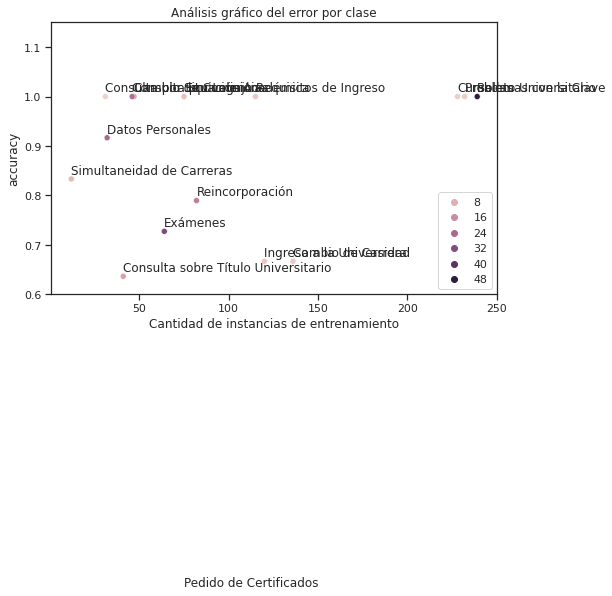

In [94]:
# Cargo las librerías y defino el paño blanco
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

# Ploteo el gráfico general
plt.figure(figsize=(8,5))

sns.scatterplot(data=df_train_error, 
                x="count_train", 
                y="accuracy", 
                hue="count_test")

# Pongo los nombres de las clases
for i in range(df_train_error.shape[0]):
#    if df_train_error.count_test[i]> df_train_error.count_test.mean():
      plt.text(x=df_train_error.count_train[i]+0.01,
              y=df_train_error.accuracy[i]+0.01,
              s=df_train_error.clase[i])

plt.title("Análisis gráfico del error por clase")           #title
# plt.xlim(df_error.score.min()-1,df_error.score.max()+1)   #set x limit
plt.ylim(0.6, 1.15)                                            #set y limit
plt.xlabel("Cantidad de instancias de entrenamiento")       #y label
plt.legend(loc='lower right')

In [25]:
import shutil
shutil.make_archive('outputs_07_ensamble_beto_210622', 'zip', 'outputs')

ENTORNO='Colab'
if ENTORNO=='Colab':
  from google.colab import drive
  drive.mount('drive')
  !cp outputs_07_ensamble_beto_210622.zip "drive/My Drive/50jaiio_modelos/"

Mounted at drive


## Referencias
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05